In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file
# GP-melt 1.0
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import torch

import pandas as pd
import numpy as np

import gpvisc

# CPU or GPU?
device = gpvisc.get_device()

Will run on cuda


# Loading dataset and model

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = gpvisc.data_loader()

# Model loading
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)

# get low pressure peridotite data
dataset_peridotite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()

Loading the viscosity datasets...


# Prediction at 1 atm

Calculation iron redox...


Text(0, 0.5, 'Viscosity, log$_{10}$ Pa$\\cdot$s')

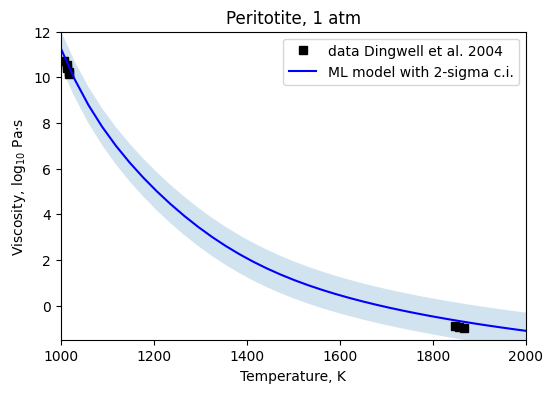

In [3]:
# prepare the query
X_peridotite = gpvisc.generate_query_single(sio2=dataset_peridotite.loc[0, "sio2"],
                                     tio2=dataset_peridotite.loc[0, "tio2"],
                                     al2o3=dataset_peridotite.loc[0, "al2o3"],
                                     feo=dataset_peridotite.loc[0, "fe2o3"],
                                     mno=dataset_peridotite.loc[0, "mno"],
                                     na2o=dataset_peridotite.loc[0, "na2o"],
                                     k2o=dataset_peridotite.loc[0, "k2o"],
                                     mgo=dataset_peridotite.loc[0, "mgo"],
                                     cao=dataset_peridotite.loc[0, "cao"],
                                     p2o5=dataset_peridotite.loc[0, "p2o5"],
                                     h2o=dataset_peridotite.loc[0, "h2o"],
                                     composition_mole = True,
                                     T_init = 1000.0, T_final= 60000.0,
                                     P_init = 0.0, P_final = 0.0,
                                     control_redox = True,
                                     fo2_init = np.log10(0.21), fo2_final = np.log10(0.21),
                                     nb_values = 2000,
                                     )

# scale the query
TPX_peridotite = gpvisc.scale_for_gaussianprocess(X_peridotite["T"], X_peridotite["P"], X_peridotite)

# make the prediction
gp_peridotite, gp_peridotite_std = gpvisc.predict(TPX_peridotite, gp_model, likelihood)

# make a figure
plt.figure(figsize=(6,4))

# plot the data
plt.plot(dataset_peridotite["T"], dataset_peridotite["viscosity"], "ks", label="data Dingwell et al. 2004")

# plot model result
plt.plot(X_peridotite["T"], gp_peridotite, "b-", label="ML model with 2-sigma c.i.")
plt.fill_between(X_peridotite["T"], 
                 gp_peridotite-2*gp_peridotite_std,
                 gp_peridotite+2*gp_peridotite_std,
                 alpha=0.2)

plt.ylim(-1.5,12)
plt.xlim(1000,2000)
plt.legend()
plt.title("Peridotite, 1 atm")
plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")


# Predictions at high pressure

Now we predict the melt viscosity at high pressure and compare results to existing data from Liebske et al. (2005, DOI:10.1016/j.epsl.2005.10.004) and Xie et al. (2021, DOI:10.1029/2021GL094507).

In [4]:
dataset_peridotite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="peridotite",:].reset_index()

This is a good opportunity to showcase how we can perform queries for specific T-P couples.

For that we will not use the `generate_single_query` function, but do things step-by-step:

*note: we here neglect the effect of pressure on the iron oxidation state. The Borisov et al. 2018 model is for 1 atm melts.*

Text(0, 0.5, 'Viscosity, log$_{10}$ Pa$\\cdot$s')

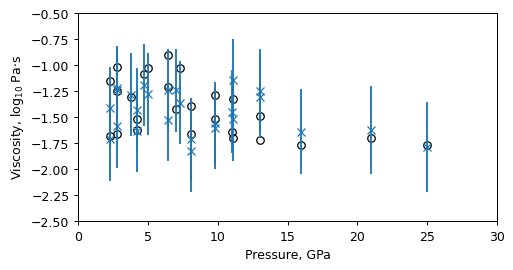

In [5]:
# check composition
X_pr = gpvisc.chimie_control(dataset_peridotite).copy()

# Fe redox recalculation
#X_pr = gpvisc.generate_query_redox(X_pr,-1*np.ones(len(X_pr)))

# transformation
tpx_pr = gpvisc.scale_for_gaussianprocess(X_pr["T"], X_pr["P"], X_pr)

# predictions
gp_pr, gp_pr_std = gpvisc.predict(tpx_pr, gp_model, likelihood)

plt.figure(figsize=(6,3), dpi=90)
plt.plot(dataset_peridotite.loc[:,"P"],dataset_peridotite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.errorbar(dataset_peridotite.loc[:,"P"],
             gp_pr, yerr=gp_pr_std,
             marker="x", linestyle="", label="model")

plt.xlim(0,30)
plt.ylim(-2.5,-0.5)
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")

*note : There is some visible scatter but remember that during high pressure experiments, temperature is not the same for all those points, such that this scatter actually results also from temperature. See paper for a better figure as well as the ./code_paper_EPSL/Pressure_effect.ipynb notebook for a better figure that suppress the effect of temperature.*